In [2]:
from reservoir import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load sample data

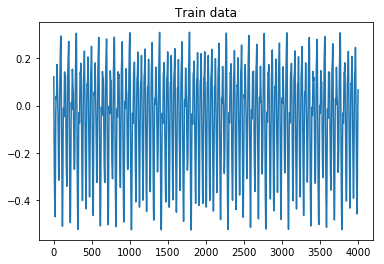

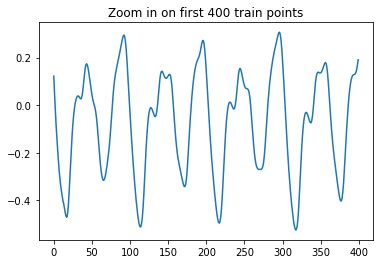

In [5]:
data = np.loadtxt('../Datasets/MackeyGlass_t17.txt')

train = data[:4000].reshape(-1, 1)
test = data[4000:6000].reshape(-1, 1)
plt.title("Train data")
plt.plot(train)
plt.show()
plt.title("Zoom in on first 400 train points")
plt.plot(train[:400])
plt.show()

### Add noise

Standard deviation of noise is: 0.108095284028


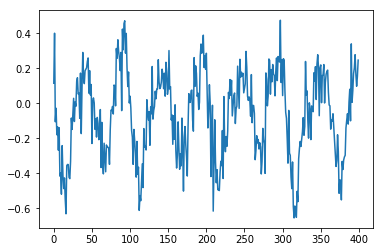

In [6]:
# Define noisy data for Bayesian Optimization
snr = 4
noise_std = np.sqrt(train.std(ddof=1)**2 / snr)

print('Standard deviation of noise is:', noise_std)
noisy_train = train + np.random.normal(0, noise_std, size=train.shape)
noisy_test = test + np.random.normal(0, noise_std, size=test.shape)
plt.plot(noisy_train[:400])
plt.show()

### Combine in multiple series

In [8]:
multiple_train = np.hstack((train, noisy_train))
multiple_test = np.hstack((test, noisy_test))

### Set bounds

In [9]:
bounds = [
    {'name': 'input_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'feedback_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'leaking_rate', 'type': 'continuous', 'domain': (0, 1)}, 
    {'name': 'spectral_radius', 'type': 'continuous', 'domain': (0, 1.25)},
    {'name': 'regularization', 'type': 'continuous', 'domain': (-12, 1)},
    {'name': 'connectivity', 'type': 'continuous', 'domain': (-3, 0)},
    {'name': 'n_nodes', 'type': 'continuous', 'domain': (100, 1500)}
]

### Optimize

In [10]:
# Set optimization parameters
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=200,
                            subsequence_length=1000,
                            eps=1e-8,
                            cv_samples=1, 
                            max_iterations=100, 
                            scoring_method='tanh',
                            verbose=True)

Model initialization and exploration run...
Objective scores: [[ 1.          0.11560613]]
Objective scores: [[ 0.06657496  0.10287145]]
Objective scores: [[ 0.0126562   0.06181667]]
Objective scores: [[ 1.          0.13916938]]
Objective scores: [[ 0.01439519  0.02016832]]
Objective scores: [[ 0.01213303  0.09820666]]
Objective scores: [[ 1.          0.17607106]]
Objective scores: [[ 0.03920093  0.04555504]]
Objective scores: [[ 0.03952667  0.05436043]]
Objective scores: [[ 1.          0.09825766]]
Objective scores: [[ 0.05140797  0.06180409]]
Objective scores: [[ 1.          0.11236814]]
Objective scores: [[ 0.01388319  0.08042307]]
Objective scores: [[ 1.  1.]]
Objective scores: [[ 0.04043392  0.11615134]]
Objective scores: [[ 0.04341098  1.        ]]
Objective scores: [[ 0.05199819  0.05200446]]
Objective scores: [[ 0.07276837  0.05550919]]
Objective scores: [[ 1.          0.07067611]]
Objective scores: [[ 0.00431206  0.07821162]]
Objective scores: [[  2.29068775e-04   1.00000000e+0

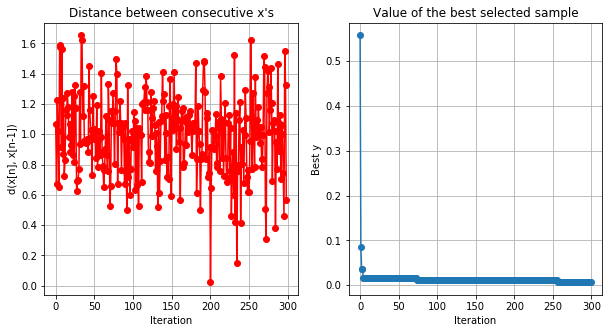

In [11]:
# Optimize (this may take a while!)
best_arguments = esn_cv.optimize(y=multiple_train)

In [14]:
# Train best model(s)
esn = EchoStateNetwork(**best_arguments)
esn.train(y=train)

esn2 = EchoStateNetwork(**best_arguments)
esn2.train(y=noisy_train)

In [17]:
# Test
score = esn.test(y=test, scoring_method='rmse')
score2 = esn.test(y=noisy_test, scoring_method='rmse')
print(score)
print(score2)

0.150213969072
0.186068355951


### Inspect performance

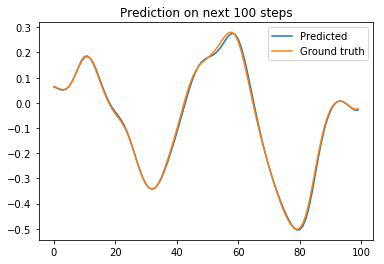

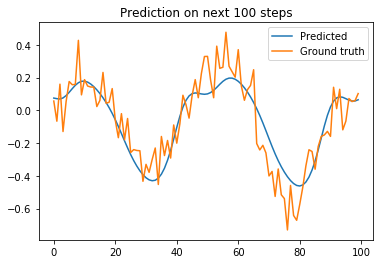

In [16]:
# Diagnostic plots
plt.plot(esn.predict(100), label='Predicted')
plt.plot(test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()

plt.plot(esn2.predict(100), label='Predicted')
plt.plot(noisy_test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()